<a href="https://colab.research.google.com/github/SvejkTheBrave/DistressedSecuritiesRecognition/blob/main/ad_fp_model_for_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle #создаем каталог .kaggle в корневой директории
! echo '{"username":"svejkthebrave","key":"9cf9b267280c85286d3bcb381ca1ca10"}' > ~/.kaggle/kaggle.json #записываем учетные данные kaggle API в kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # устанавливаем разрешения 
! pip install kaggle #устанавливаем библиотеку kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.4 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=81f5758e8aabcced531cef7f70a689274bfe2db3f2e909dacdf3e2930bb16cf3
  Stored in directory: /home/codespace/.cache/pip/wheels/fb/01/d5/daa97ea9d89ceec9c6c76fad6fe97165661fd2236c46f83354
Successfully built kaggle


#Библиотеки, линейные модели

In [2]:
import numpy as np
import pandas as pd
from numpy.ma.core import size
import matplotlib
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
#from pandas import random_state
%matplotlib inline

ModuleNotFoundError: No module named 'imblearn'

#Постановка задачи

При управлении портфелем ценных бумаг с фиксированной доходностью (облигации, кредиты, т.п. инструменты, по которым понятен будущий поток платежей, обычно используется сокращение FI для этой категориеи) не хочется держать бумагу, по которой через, скажем, год будет объявлен дефолт. Обычно дефолт (или даже переход бумаги в категорию существено более высокого риска) не происходит совсем уж неожиданно, предваряясь существенным ухудщением кредитных метрик эмитента (компания, выпустившая ценную бумагу), снижением стоимости его акций, если таковые торгуются и т.п. Собственно, начало такого системного ухудшения и хочется отследить для того, чтобы, например, заранее избавиться от такой бумаги. 

Модели для управления риском, позволяющие, в том числе, и такое, есть, например, у Moody's (они есть у всех рейтинговых агентств, но эти предлагают на основе такой модели продукт, доступный клиенту). Тем не менее, поскольку данные о крединтых метриках эмитента, цене его ценных бумаг доступны, на их основе хочется построить собственную модель. Которую потом регулярно использовать. 
В жизни задача заключается в том, чтобы на основе данных за предыдущий период, выделить среди присутствующих в портфеле бумаг наиболее рискованные.

Для реальной модели планируется брать кредитные метрики эмитента, статистику по его ценным бумагам (оценку ликвидности, размер спреда относительно среднего по выборке аналогичных инструментов и т.п.)

Но так получилось, что во-время собрать такой рабочий набор данных не вышло, поэтому пришлось на найденных в открытом доступе наборах потестировать подход как таковой - более простую задачу о том, способна ли модель по кредитным метрикам отобрать дефолтного эмитента.

Дополнительно неплохо иметь инструмент, который на основании имеющихся данных отчетности компании поможет оценить рейтинг бумаги - такая модель будет полезна, поскольку часто в портфеле имеются бумаги, которым никакой рейтинг не присвоен и для таких, в рамках процесса управления риском портфеля, управляющий должен сам оценить рейтинг. 

Таким образом, все дальнейшее находится пока довольно далеко от применения на практике и является, скорее, проверкой потенциала применения моделей к решению задачи.
Для решения задачи собираюсь использовать линейные модели, Decision Trees, поскольку они дают возможность оценить значимость факторов. В дальнейшем с учетом результатов буду конструировать набор данных для решения своей задачи.

#Загрузка данных

Нашлось 3 набора данных:

https://www.kaggle.com/datasets/agewerc/corporate-credit-rating

https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

https://www.kaggle.com/datasets/yashsaxena005/corporate-credit-risk

Первый, предсказание рейтинга компании, включает данные по кредитным рейтингам, присвоенным американским компаниям в разные даты и их отчетность на этот момент. 

Во втором и третьем наборах содержатся данные отчетности компаний и в качестве целевой переменной - отметка, находится ли компания в дефолте.

По первому набору хочется на основании данных отчетности отсортировать с помощью модели компании, попадающие в группу риска (рейтинг В и ниже). Как раз такая модель может применяться для самостоятельной оценки рейтинга компании - попадает ли этот рейтинг в категорию рискованных.

In [ ]:
#! kaggle datasets download -h
! kaggle datasets download -d agewerc/corporate-credit-rating
! echo "r"| unzip corporate-credit-rating.zip 
! kaggle datasets download -d fedesoriano/company-bankruptcy-prediction
! echo "r"| unzip company-bankruptcy-prediction.zip 
! kaggle datasets download -d yashsaxena005/corporate-credit-risk
! echo "r"| unzip corporate-credit-risk.zip 

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 75.5MB/s]
Archive:  corporate-credit-rating.zip
  inflating: corporate_rating.csv    
  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 119MB/s]
Archive:  company-bankruptcy-prediction.zip
  inflating: data.csv                
  0% 0.00/543k [00:00<?, ?B/s]
100% 543k/543k [00:00<00:00, 90.1MB/s]
Archive:  corporate-credit-risk.zip
  inflating: corporate_credit_risk.csv  


#Функции

Для аугментации данных

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
scl = StandardScaler()

In [ ]:
def augm3(X_train, y_train):
  augm_a = ADASYN(random_state = 12)
  augm_s = SMOTE(random_state=12)
  augm_r = RandomUnderSampler(random_state=12, replacement=True)
  X_a_train, y_a_train = augm_a.fit_resample(np.array(X_train), np.array(y_train))
  X_s_train, y_s_train = augm_s.fit_resample(np.array(X_train), np.array(y_train))
  X_r_train, y_r_train = augm_r.fit_resample(np.array(X_train), np.array(y_train))
  return  X_a_train, y_a_train, X_s_train, y_s_train,  X_r_train, y_r_train


In [ ]:
def conf_matrix(y_test, prd):
  fig = plt.figure(figsize=(8,8))
  nn_mtx = mt.confusion_matrix(y_test, prd)
  print(nn_mtx)
  font = {'weight' : 'bold', 'size'   :22}
  matplotlib.rc('xtick', labelsize=20) 
  matplotlib.rc('ytick', labelsize=20) 
  sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])
  plt.ylabel("Real value")
  plt.xlabel("Predicted value")


In [ ]:
from sklearn.metrics import f1_score, make_scorer, recall_score, accuracy_score
f1 = make_scorer(f1_score, average = 'weighted')
recall_s = make_scorer(recall_score, average = 'weighted')
accuracy = make_scorer(accuracy_score, average = 'weighted')

#1-й набор. Сортируем на "норм" и "проблемки"

##Загрузка данных, датасет "Предсказание корпоративного рейтинга"

In [ ]:
df = pd.read_csv('corporate_rating.csv')
df.head(5).T

,0,1,2,3,4
Rating,A,BBB,BBB,BBB,BBB
Name,Whirlpool Corporation,Whirlpool Corporation,Whirlpool Corporation,Whirlpool Corporation,Whirlpool Corporation
Symbol,WHR,WHR,WHR,WHR,WHR
Rating Agency Name,Egan-Jones Ratings Company,Egan-Jones Ratings Company,Fitch Ratings,Fitch Ratings,Standard & Poor's Ratings Services
Date,11/27/2015,2/13/2014,3/6/2015,6/15/2012,10/24/2016
Sector,Consumer Durables,Consumer Durables,Consumer Durables,Consumer Durables,Consumer Durables
currentRatio,0.945894,1.033559,0.963703,1.019851,0.957844
quickRatio,0.426395,0.498234,0.451505,0.510402,0.495432
cashRatio,0.09969,0.20312,0.122099,0.176116,0.141608
daysOfSalesOutstanding,44.203245,38.991156,50.841385,41.161738,47.761126


Этот набор данных идет прямо с названиями компании, другие такой информации не содержат.

##Проверка данных на пропуски, дубликаты...

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rating                              2029 non-null   object 
 1   Name                                2029 non-null   object 
 2   Symbol                              2029 non-null   object 
 3   Rating Agency Name                  2029 non-null   object 
 4   Date                                2029 non-null   object 
 5   Sector                              2029 non-null   object 
 6   currentRatio                        2029 non-null   float64
 7   quickRatio                          2029 non-null   float64
 8   cashRatio                           2029 non-null   float64
 9   daysOfSalesOutstanding              2029 non-null   float64
 10  netProfitMargin                     2029 non-null   float64
 11  pretaxProfitMargin                  2029 no

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
currentRatio,2029.0,3.529607,44.052361,-0.932005,1.071930,1.493338,2.166891,1.725505e+03
quickRatio,2029.0,2.653986,32.944817,-1.893266,0.602825,0.985679,1.453820,1.139542e+03
cashRatio,2029.0,0.667364,3.583943,-0.192736,0.130630,0.297493,0.624906,1.259174e+02
daysOfSalesOutstanding,2029.0,333.795606,4447.839583,-811.845623,22.905093,42.374120,59.323563,1.159616e+05
netProfitMargin,2029.0,0.278447,6.064134,-101.845815,0.021006,0.064753,0.114807,1.985179e+02
pretaxProfitMargin,2029.0,0.431483,8.984982,-124.343612,0.025649,0.084965,0.144763,3.096949e+02
grossProfitMargin,2029.0,0.497968,0.525307,-14.800817,0.233127,0.414774,0.849693,2.702533e+00
operatingProfitMargin,2029.0,0.587322,11.224622,-124.343612,0.044610,0.107895,0.176181,4.101822e+02
returnOnAssets,2029.0,-37.517928,1166.172220,-40213.178290,0.019176,0.045608,0.077468,4.878257e-01
returnOnCapitalEmployed,2029.0,-73.974193,2350.275719,-87162.162160,0.028112,0.074421,0.135036,2.439504e+00


Ни повторов, ни дубликатов не нашлось.

In [ ]:
ratings = sorted(df.Rating.unique())
ratings

['A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC', 'D']

Посмотрю, сколько компаний попадает в каждый рейтинг.

In [ ]:
df.groupby('Rating')['Name'].count()

Rating
A      398
AA      89
AAA      7
B      302
BB     490
BBB    671
C        2
CC       5
CCC     64
D        1
Name: Name, dtype: int64

Ожидаемо с низкими рейтингами относительно мало компаний. Одна из причин, рейтинговые агентства часто отзывают рейтинг еще до того, как компания "встретится" с большими проблемами.

Делить компании буду на 2 категории - выше В и ниже.

##Кодировка рейтингов и проверка балансировки класов

Заведу в dataframe колонку target, где будет 0, если рейтинг ниже В и 1, если выше.

In [ ]:
df['target']=0
rtg_range ={1: ['AAA', 'AA', 'A', 'BBB','BB'],            
            0: ['B', 'CCC', 'CC', 'C', 'D']
}

In [ ]:
def coder(rtg, rtg_range):
  for a in rtg_range.keys():
    if rtg in rtg_range[a]:
      return a

df['target'] = df['Rating'].apply(lambda x: coder(x, rtg_range))
df.groupby('target')['target'].count()

target
0     374
1    1655
Name: target, dtype: int64

In [ ]:
df.groupby('target')['target'].count()[0]/df.groupby('target')['target'].count()[1]

0.22598187311178247

Итак, компаний с рейтингов ниже В нашлось 22,6% от общего числа.

In [ ]:
len(df['Name'].unique())

593

Список колонок:

In [ ]:
cols=df.columns.tolist()
cols[6:]

['currentRatio',
 'quickRatio',
 'cashRatio',
 'daysOfSalesOutstanding',
 'netProfitMargin',
 'pretaxProfitMargin',
 'grossProfitMargin',
 'operatingProfitMargin',
 'returnOnAssets',
 'returnOnCapitalEmployed',
 'returnOnEquity',
 'assetTurnover',
 'fixedAssetTurnover',
 'debtEquityRatio',
 'debtRatio',
 'effectiveTaxRate',
 'freeCashFlowOperatingCashFlowRatio',
 'freeCashFlowPerShare',
 'cashPerShare',
 'companyEquityMultiplier',
 'ebitPerRevenue',
 'enterpriseValueMultiple',
 'operatingCashFlowPerShare',
 'operatingCashFlowSalesRatio',
 'payablesTurnover',
 'target']

## Матрица корреляций признаков

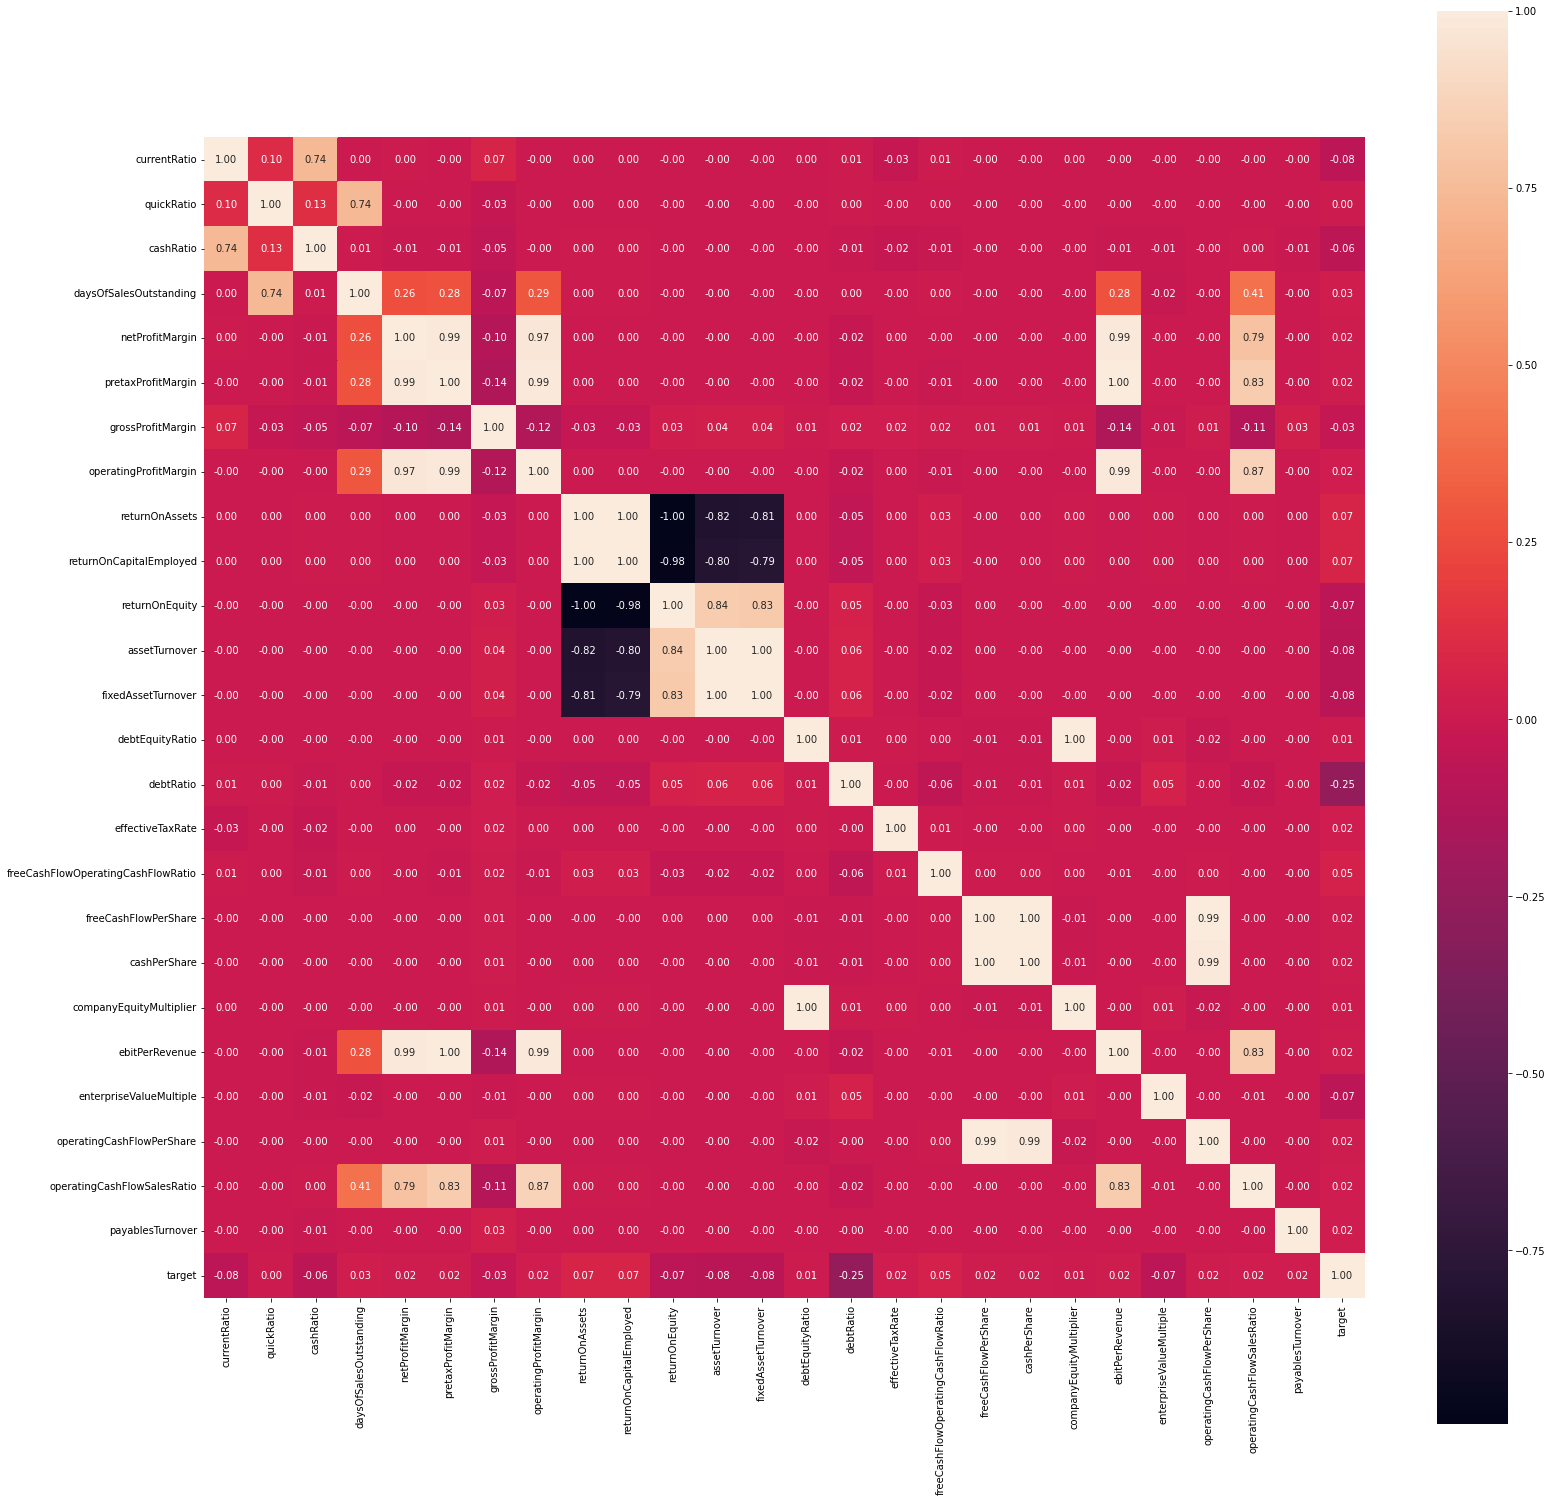

In [ ]:
plt.subplots(figsize=(26,26))
sns.heatmap(df[cols[6:]].corr(), fmt=".2f", annot=True, square=True)

Тут видно, что некоторые признаки коррелированы (зависимы). Однако пока ничего выбрасывать не стал, поскольку, скажем, EBIT/Revenue и OperatingProfitMargin в нормальной ситуации, конечно, зависимы, но вот в балансах рискованных эмитентов могут случаться "чудеса", что вполне может быть их отличительным признаком.

##Кодирование и нормирование данных

In [ ]:
# При помощи OneHot кодирую категориальные признаки - сектор, в котором рействует компаний и название рейтингового агентства.
XXX = enc.fit_transform(df[['Sector','Rating Agency Name']]).toarray()
feature_names = enc.get_feature_names_out(df[['Sector','Rating Agency Name']].columns) #
nums = df[df.drop(columns=['target','Sector','Rating','Symbol','Rating Agency Name','Date','Name']).columns]
feature_names_nums = list(nums.columns)
nums = scl.fit_transform(nums)
XXX = pd.DataFrame(XXX, columns = feature_names)
nums = pd.DataFrame(nums, columns = feature_names_nums)
X = pd.concat([nums, XXX], axis = 1, ignore_index = False)
y = df['target']

In [ ]:
list(nums.columns)

['currentRatio',
 'quickRatio',
 'cashRatio',
 'daysOfSalesOutstanding',
 'netProfitMargin',
 'pretaxProfitMargin',
 'grossProfitMargin',
 'operatingProfitMargin',
 'returnOnAssets',
 'returnOnCapitalEmployed',
 'returnOnEquity',
 'assetTurnover',
 'fixedAssetTurnover',
 'debtEquityRatio',
 'debtRatio',
 'effectiveTaxRate',
 'freeCashFlowOperatingCashFlowRatio',
 'freeCashFlowPerShare',
 'cashPerShare',
 'companyEquityMultiplier',
 'ebitPerRevenue',
 'enterpriseValueMultiple',
 'operatingCashFlowPerShare',
 'operatingCashFlowSalesRatio',
 'payablesTurnover']

И еще раз проверил на дубликаты

In [ ]:
X.duplicated().sum()

0

##Деление данных на train и test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify= y, shuffle=True)
X_train.reset_index(drop = True, inplace=True)
X_test.reset_index(drop = True, inplace=True)
y_train.reset_index(drop = True, inplace=True)
y_test.reset_index(drop = True, inplace=True)
len(y_test)

406

##Модели на данных без аугментации

###Логистическая регрессия

In [ ]:
%%time
clf = LogisticRegression(max_iter = 400, class_weight = 'balanced')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      0.72      0.45        75
           1       0.91      0.67      0.77       331

    accuracy                           0.68       406
   macro avg       0.62      0.70      0.61       406
weighted avg       0.81      0.68      0.71       406

CPU times: user 134 ms, sys: 126 ms, total: 260 ms
Wall time: 235 ms


У логистической регрессии "из коробки" неплохой recall.

###Градиентный бустинг

In [ ]:
%%time
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
pred = gbc.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.35      0.48        75
           1       0.87      0.98      0.92       331

    accuracy                           0.86       406
   macro avg       0.82      0.66      0.70       406
weighted avg       0.85      0.86      0.84       406

CPU times: user 1.41 s, sys: 2.45 ms, total: 1.42 s
Wall time: 1.42 s


In [ ]:
gbc = GradientBoostingClassifier()
params = {'loss' : ['exponential'],
          'learning_rate' : np.array(np.linspace(0.1,1,5)),
          'n_estimators' : [200],
          'subsample' : np.array(np.linspace(0.001,1,5)),
          'criterion' : ['friedman_mse', 'squared_error']         
          }

In [ ]:
%%time
grd_gradboost = GridSearchCV(gbc, params, scoring = f1, cv=3).fit(X_train, y_train)
prd_gradboost = grd_gradboost.predict(X_test)
print(metrics.classification_report(y_test, prd_gradboost))

              precision    recall  f1-score   support

           0       0.76      0.47      0.58        75
           1       0.89      0.97      0.93       331

    accuracy                           0.87       406
   macro avg       0.82      0.72      0.75       406
weighted avg       0.87      0.87      0.86       406

CPU times: user 2min 30s, sys: 253 ms, total: 2min 30s
Wall time: 2min 32s


In [ ]:
grd_gradboost.best_params_, grd_gradboost.best_score_

({'criterion': 'squared_error',
  'learning_rate': 0.325,
  'loss': 'exponential',
  'n_estimators': 200,
  'subsample': 1.0},
 0.8581383568859143)

In [ ]:
#scoring = ['accuracy', 'precision', 'recall', 'f1']
#scores = cross_validate(gbc, X, y, scoring = scoring, verbose = 1)
#print('Accuracy = ', round(scores['test_accuracy'].mean(),3), 'F1 = ', round(scores['test_f1'].mean(),3))

[[ 35  40]
 [ 11 320]]


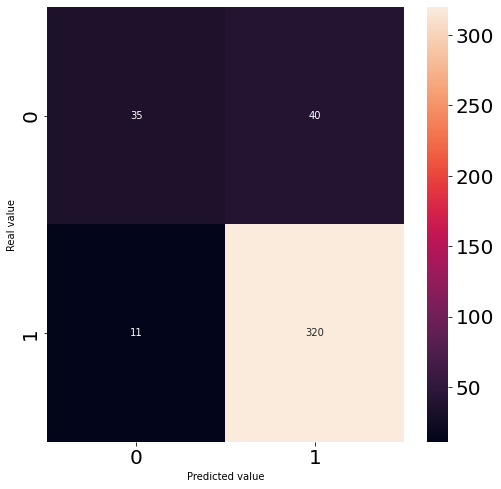

In [ ]:
conf_matrix(y_test, prd_gradboost)

Градиентный бустинг пропускает после подбора параметров больше рискованных, чем находит, что выражается в низком recall. Для управляющего это, с учетом постановки задачи, хуже, чем неправильно приписать эмитенту более низкий рейтинг, поскольку потенциальный дефолт - более крупная неприятность, чем даже необоснованное исключение бумаги из портфеля. В последнем случае убыток - комиссии при продаже, при дефоолте - существенная доля номинала бумаги.

### RandomForest

In [ ]:
%%time
rfc = RandomForestClassifier()
clf = AdaBoostClassifier(base_estimator = rfc, algorithm='SAMME', random_state = 12)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.41      0.55        75
           1       0.88      0.98      0.93       331

    accuracy                           0.87       406
   macro avg       0.85      0.70      0.74       406
weighted avg       0.87      0.87      0.86       406

CPU times: user 710 ms, sys: 3.94 ms, total: 714 ms
Wall time: 719 ms


In [ ]:
abc_cl = AdaBoostClassifier()
params_a = {'learning_rate' : np.array(np.linspace(0.001,3,10)),
          'n_estimators' : [50,100,200]       
          }

In [ ]:
%%time
grd_abc = GridSearchCV(abc_cl, params_a, scoring = 'f1', cv=4).fit(X_train, y_train)
prd = grd_abc.predict(X_test)
print(metrics.classification_report(y_test, prd))

              precision    recall  f1-score   support

           0       0.74      0.41      0.53        75
           1       0.88      0.97      0.92       331

    accuracy                           0.86       406
   macro avg       0.81      0.69      0.73       406
weighted avg       0.85      0.86      0.85       406

CPU times: user 1min 25s, sys: 272 ms, total: 1min 26s
Wall time: 1min 32s


In [ ]:
grd_abc.best_params_, grd_abc.best_score_

({'learning_rate': 0.33422222222222225, 'n_estimators': 200},
 0.9131410888561022)

##Аугментированные данные

In [ ]:
X_train_adasyn, y_train_adasyn, X_train_smote, y_train_smote, X_train_rus, y_train_rus = augm3(X_train, y_train)

### RandomForest

In [ ]:
%%time
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train_adasyn), np.array(y_train_adasyn))
preds = rfc.predict(np.array(X_test))
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        75
           1       0.94      0.92      0.93       331

    accuracy                           0.89       406
   macro avg       0.82      0.84      0.83       406
weighted avg       0.90      0.89      0.90       406

CPU times: user 864 ms, sys: 3.95 ms, total: 868 ms
Wall time: 865 ms


[[ 57  18]
 [ 25 306]]


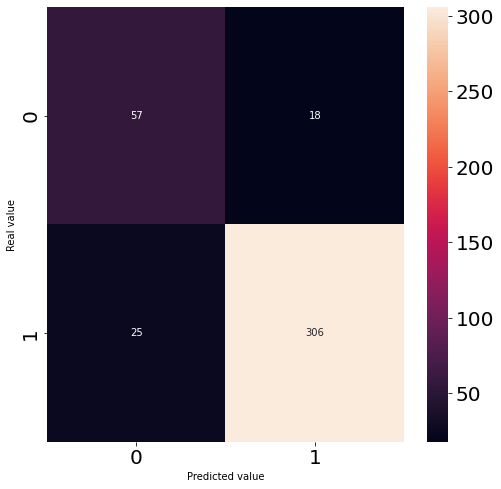

In [ ]:
conf_matrix(y_test, preds)

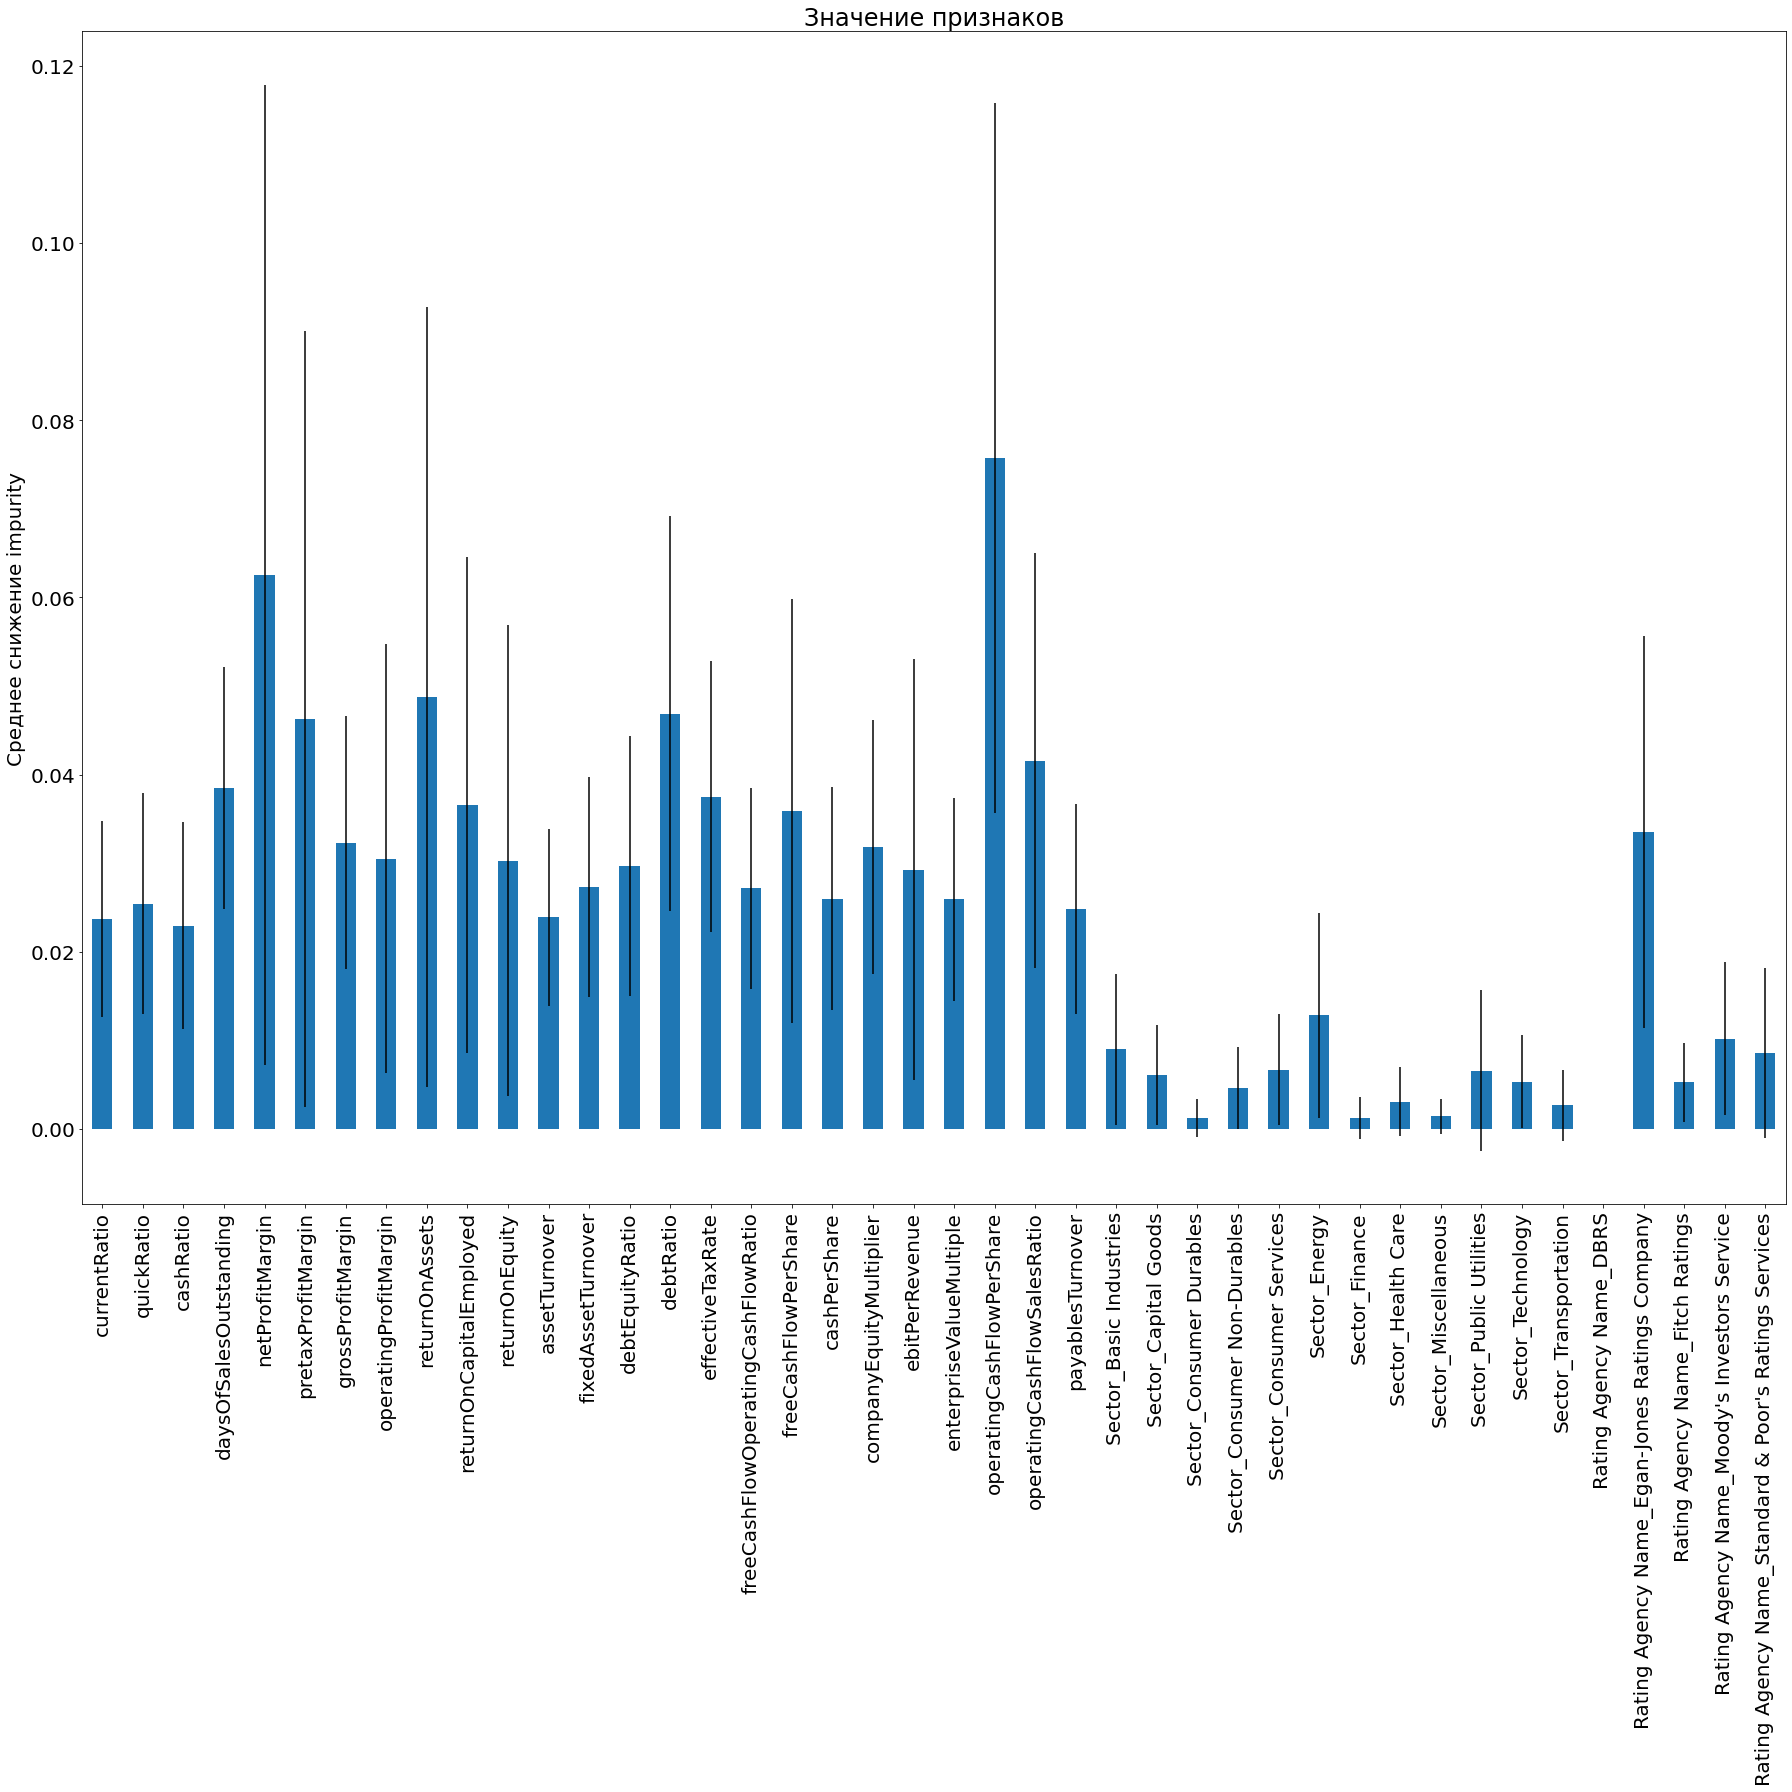

In [ ]:
importances = rfc.feature_importances_
feature_names = list(X_train.columns.values)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize = (25,25))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Значение признаков", size = 24)
ax.set_ylabel("Среднее снижение impurity", size = 20)
fig.tight_layout()

Random Forest с настройками "по умолчанию" показывает F1 на уровне выше 70%. По значимости выделяется несколько признаков, связанных с прибыльностью, долговой нагрузкой, что вполне логично. 

Подберу параметры для Random Forest:

In [ ]:
%%time
rfc_test = RandomForestClassifier(random_state = 12)
rfc_grid = {'criterion' : ['gini', 'entropy'],
            'n_estimators': [50, 100, 200],        
            'max_depth': [5,7,10,20,30],
            'max_features': [5,6,7,8,9,10,11,12],                                  
            }
opt_srch = GridSearchCV(estimator = rfc_test, param_grid = rfc_grid, scoring = f1, refit = True, cv = 3)
opt_srch.fit(X_train_adasyn, y_train_adasyn)
opt_srch.best_params_, opt_srch.best_score_##

CPU times: user 12min 9s, sys: 2 s, total: 12min 11s
Wall time: 12min 23s


({'criterion': 'gini',
  'max_depth': 20,
  'max_features': 7,
  'n_estimators': 100},
 0.8999531689052516)

In [ ]:
preds = opt_srch.predict(X_test)
print(metrics.classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        75
           1       0.94      0.92      0.93       331

    accuracy                           0.89       406
   macro avg       0.82      0.84      0.83       406
weighted avg       0.90      0.89      0.90       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[ 57  18]
 [ 25 306]]


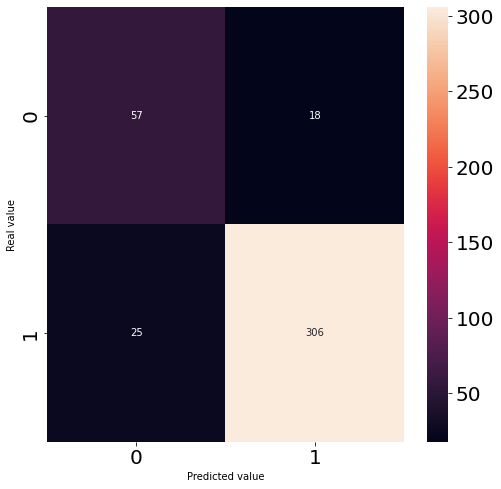

In [ ]:
conf_matrix(y_test, preds)

Интересно, но подбор параметров ничего особо не дал.

###Adaboost

In [ ]:
rfc1 = AdaBoostClassifier(base_estimator = rfc, 
                          algorithm='SAMME', 
                          random_state = 12, 
                          learning_rate = 0.334,
                          n_estimators = 200)
rfc1 = rfc1.fit(X_train_adasyn, y_train_adasyn)
pred = rfc1.predict(X_test)
print(metrics.classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.68      0.76      0.72        75
           1       0.94      0.92      0.93       331

    accuracy                           0.89       406
   macro avg       0.81      0.84      0.82       406
weighted avg       0.90      0.89      0.89       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


[[ 57  18]
 [ 27 304]]


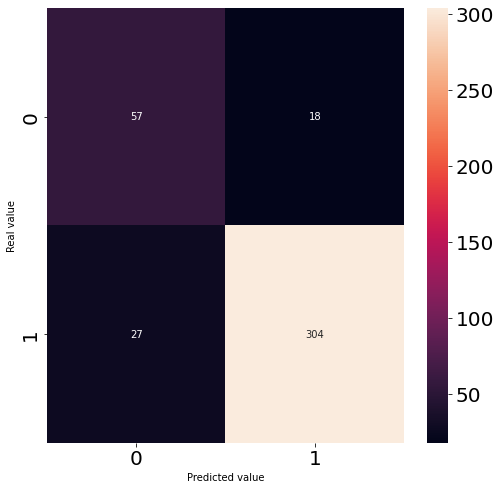

In [ ]:
conf_matrix(y_test, pred)

In [ ]:
rfc2 = AdaBoostClassifier(base_estimator = rfc, 
                          algorithm='SAMME', 
                          random_state = 12, 
                          learning_rate = 0.334,
                          n_estimators = 200)
rfc2 = rfc2.fit(X_train_smote, y_train_smote)
pred = rfc1.predict(X_test)
print(metrics.classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.68      0.76      0.72        75
           1       0.94      0.92      0.93       331

    accuracy                           0.89       406
   macro avg       0.81      0.84      0.82       406
weighted avg       0.90      0.89      0.89       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


[[ 57  18]
 [ 27 304]]


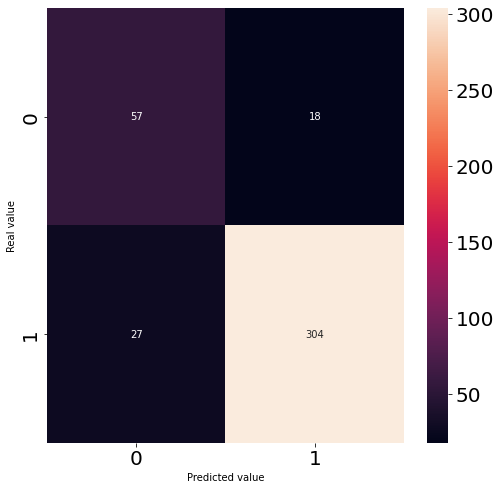

In [ ]:
conf_matrix(y_test, pred)

In [ ]:
rfc3 = AdaBoostClassifier(base_estimator = rfc, 
                          algorithm='SAMME', 
                          random_state = 12, 
                          learning_rate = 0.334,
                          n_estimators = 200)
rfc3 = rfc3.fit(X_train_rus, y_train_rus)
pred = rfc3.predict(X_test)
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.47      0.87      0.61        75
           1       0.96      0.78      0.86       331

    accuracy                           0.80       406
   macro avg       0.72      0.82      0.74       406
weighted avg       0.87      0.80      0.82       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


[[ 65  10]
 [ 73 258]]


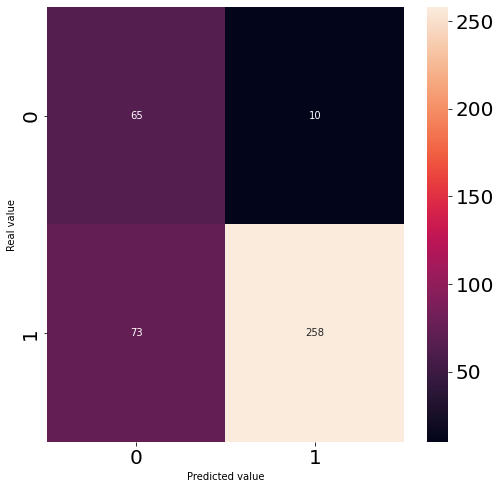

In [ ]:
conf_matrix(y_test, pred)

На аугментированных данных AdaBoost показывает наилучший recall с Random Undersampling. Собственно, если не бояться приписывать эмитенту более низкий рейтинг, чем он того заслуживает, вполне можно пользоваться моделью.

###GradientBoosting

In [ ]:
gbc1 = GradientBoostingClassifier( criterion = 'friedman_mse',
                                  learning_rate = 0.1,
                                  loss = 'exponential',
                                  n_estimators = 200,
                                  subsample = 0.25075)
gbc1.fit(X_train_adasyn, y_train_adasyn)
pred = gbc1.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71        75
           1       0.95      0.90      0.92       331

    accuracy                           0.88       406
   macro avg       0.80      0.84      0.82       406
weighted avg       0.89      0.88      0.88       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


[[ 59  16]
 [ 33 298]]


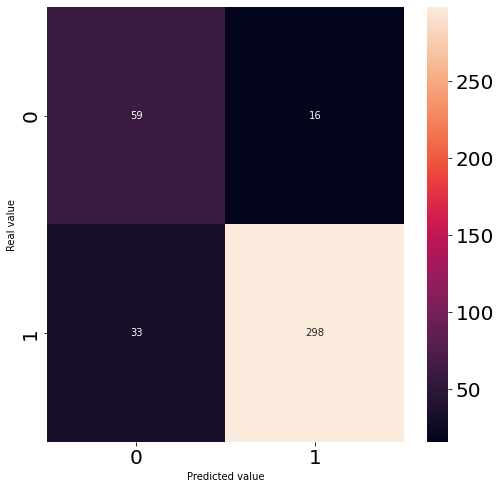

In [ ]:
conf_matrix(y_test, pred)

GradientBoosting "выступил" примерно так же, как и AdaBoost

###Ансамбль моделей

Попробую, как с задачей справляется ансамболь модетей:

In [ ]:
#Список моделей для ансамбля
estimators=[('log_regr', clf), ('AdaBoost', grd_abc), ('GradBoost', grd_gradboost)]
#Собственно, ансамбль:
ensemble = VotingClassifier(estimators, voting='hard')


In [ ]:
%%time
ensemble = ensemble.fit(X_train_adasyn, y_train_adasyn)

CPU times: user 6min 4s, sys: 906 ms, total: 6min 5s
Wall time: 6min 6s


In [ ]:
y_pred_ens = ensemble.predict(X_test)
print(metrics.classification_report(y_test, y_pred_ens))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72        75
           1       0.95      0.92      0.93       331

    accuracy                           0.89       406
   macro avg       0.81      0.85      0.83       406
weighted avg       0.90      0.89      0.89       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


[[ 58  17]
 [ 27 304]]


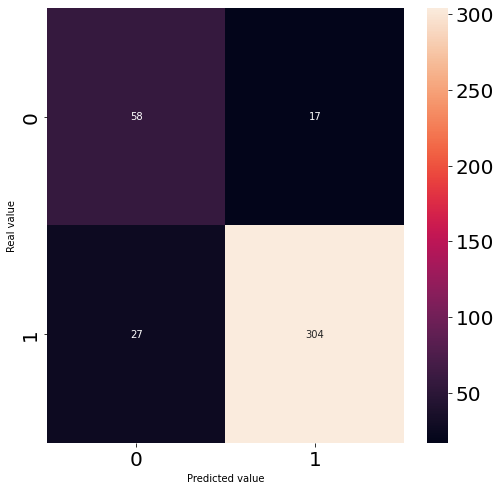

In [ ]:
conf_matrix(y_test, y_pred_ens)

Ансамбль, кроме того, что работает существенно дольше, преимущества в качестве не показал. Можно дальше попробовать включать другие модели...

После всего хочется посмотреть на список компаний, которые регулятно относятся к менее рискованным, чем есть на самом деле (в этот раздел попадает 10-18 компаний). Для этого "классифицирую" сразу весь набор данных без перемешивания с тем, чтобы "добыть" имена:

In [ ]:
pred_global = ensemble.predict(X)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
print(metrics.classification_report(y, pred_global))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       374
           1       0.99      0.98      0.99      1655

    accuracy                           0.98      2029
   macro avg       0.96      0.97      0.96      2029
weighted avg       0.98      0.98      0.98      2029



[[ 357   17]
 [  27 1628]]


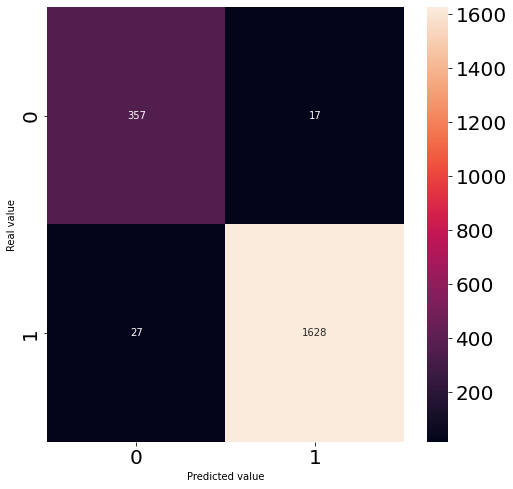

In [ ]:
conf_matrix(y, pred_global)

In [ ]:
df[(y==0)&(pred_global==1)]['Name']

304                              Transocean Ltd.
939                            Ferro Corporation
951                             V.F. Corporation
1012                            PBF Logistics LP
1095                    Century Aluminum Company
1147                    Vulcan Materials Company
1310           Service Corporation International
1342                                  Belden Inc
1378                        Kronos Worldwide Inc
1379                        Kronos Worldwide Inc
1404                   PRA Health Sciences, Inc.
1572                Natural Resource Partners LP
1601                         Oshkosh Corporation
1711                         Post Holdings, Inc.
1869                  Xinyuan Real Estate Co Ltd
1959        Quanex Building Products Corporation
2019    IRSA Inversiones Y Representaciones S.A.
Name: Name, dtype: object

###Decision Tree и простенькая сеть

In [ ]:
dtr = DecisionTreeClassifier()# criterion = 'gini', max_features = 7, 
                             # max_leaf_nodes = 13, min_samples_leaf= 8)
dtr.fit(np.array(X_train), np.array(y_train))
preds = dtr.predict(np.array(X_test))
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.49      0.44      0.46        75
           1       0.88      0.90      0.89       331

    accuracy                           0.81       406
   macro avg       0.68      0.67      0.68       406
weighted avg       0.81      0.81      0.81       406



In [ ]:
%%time
dtc_test = DecisionTreeClassifier(random_state = 12)
dtc_grid = {'min_samples_leaf': np.array([2,3,4,5,6,7,8,9,10]),
            'max_leaf_nodes': np.array([5,6,7,8,9,10,11,12,13,14,15]), 
            'criterion' : ['gini', 'entropy'],
            'max_features': np.array([5,6,7,8,9,10,11,12])}
opt_srch = GridSearchCV(dtc_test, dtc_grid, scoring = recall_s, cv = 3)
opt_srch.fit(X_train, y_train)
opt_srch.best_params_, opt_srch.best_score_

CPU times: user 47.7 s, sys: 221 ms, total: 47.9 s
Wall time: 48 s


({'criterion': 'gini',
  'max_features': 9,
  'max_leaf_nodes': 7,
  'min_samples_leaf': 10},
 0.8465804066543439)

In [ ]:
preds = opt_srch.predict(X_test)
print(metrics.classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.61      0.25      0.36        75
           1       0.85      0.96      0.90       331

    accuracy                           0.83       406
   macro avg       0.73      0.61      0.63       406
weighted avg       0.81      0.83      0.80       406



[[ 19  56]
 [ 12 319]]


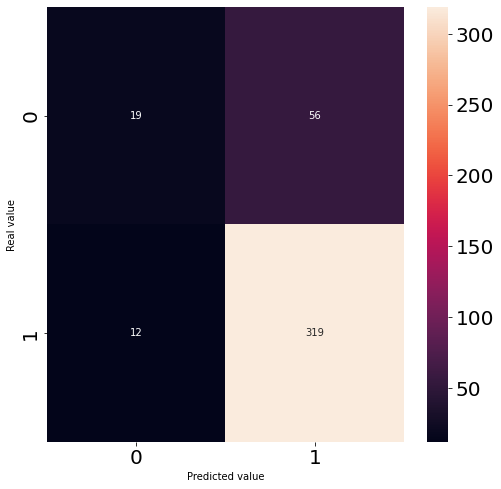

In [ ]:
conf_matrix(y_test, preds)

In [ ]:
dtc_a = DecisionTreeClassifier(criterion = 'gini',
                               max_features = 9,
                               max_leaf_nodes = 7,
                               min_samples_leaf = 10,
                               random_state = 12)
dtc_a = dtc_a.fit(X_train_adasyn, y_train_adasyn)
pr_dtc = dtc_a.predict(X_test)
print(metrics.classification_report(y_test,pr_dtc))

              precision    recall  f1-score   support

           0       0.37      0.85      0.51        75
           1       0.95      0.66      0.78       331

    accuracy                           0.70       406
   macro avg       0.66      0.76      0.65       406
weighted avg       0.84      0.70      0.73       406



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


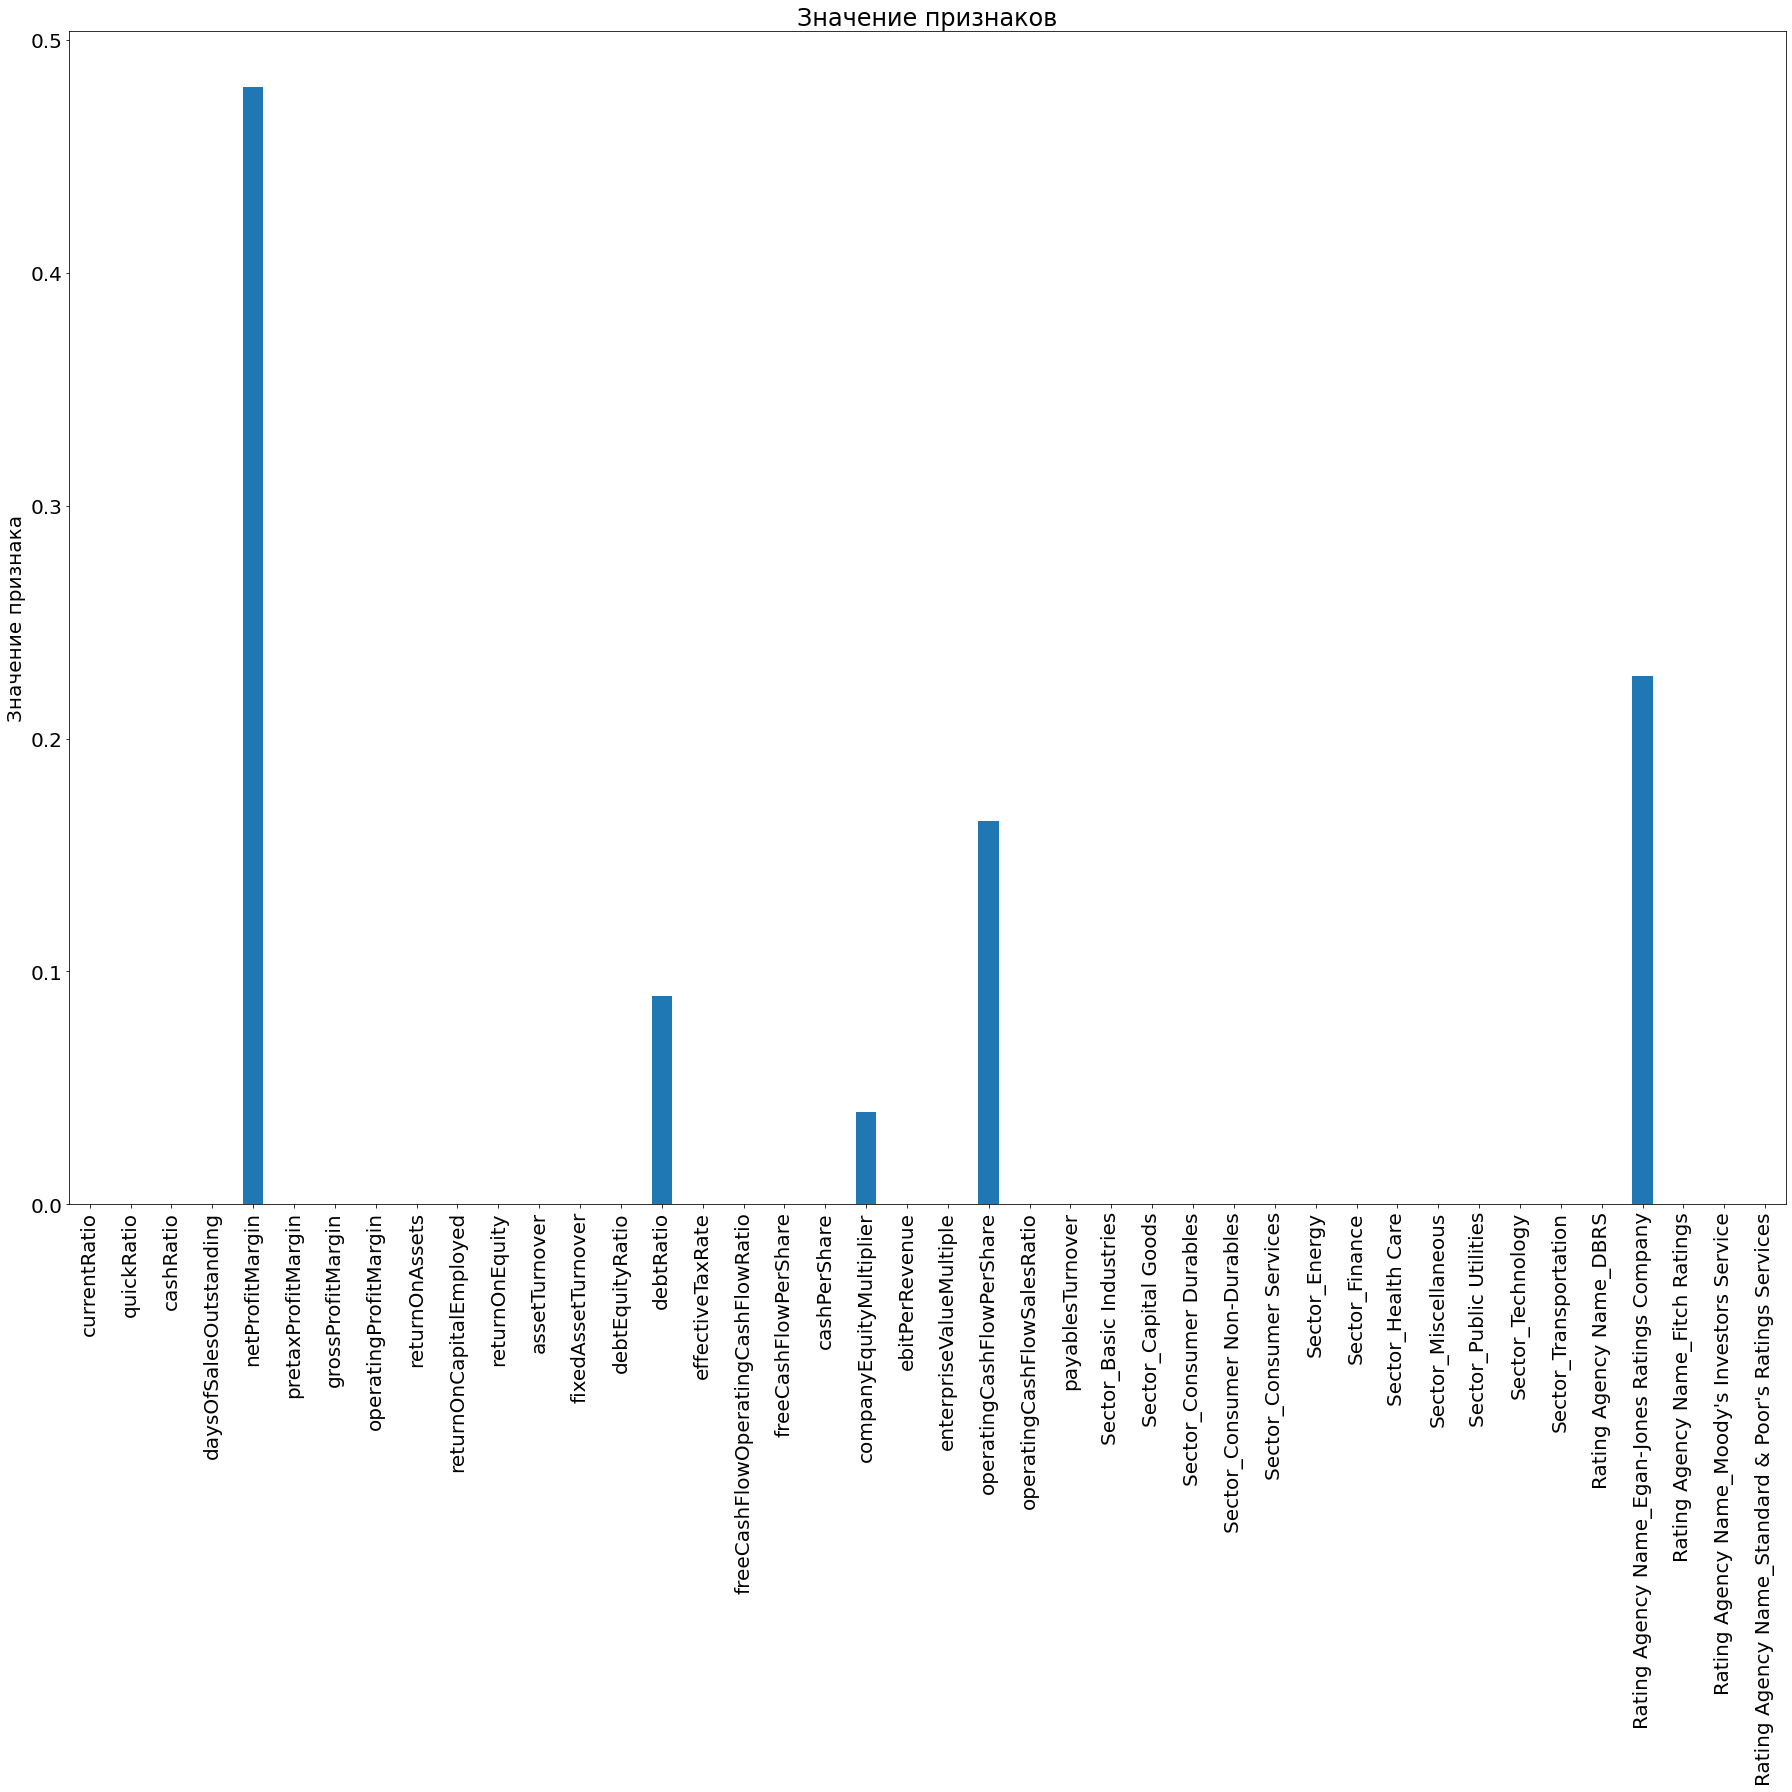

In [ ]:
importances_l = dtc_a.feature_importances_
feature_names_l = list(X_train.columns.values)
tree_importances = pd.Series(importances_l, index=feature_names_l)
fig, ax = plt.subplots(figsize = (25,25))
tree_importances.plot.bar(ax=ax)
ax.set_title("Значение признаков", size = 24)
ax.set_ylabel("Значение признака", size = 20)
fig.tight_layout()

Очень интересно, что Decision Tree классифицирует на основании всего-то 5 признаков.

In [ ]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support
from torchvision import models
import tensorflow as tf
%matplotlib inline

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(42, 504,dtype=torch.float64)
        self.fc2 = nn.Linear(504, 504,dtype=torch.float64)
        self.dropout2 = nn.Dropout(0.1) 
        self.fc3 = nn.Linear(504, 504,dtype=torch.float64)
        #self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(504, 504,dtype=torch.float64)
        self.dropout4 = nn.Dropout(0.05)
        self.fc5 = nn.Linear(504, 504,dtype=torch.float64)
        #self.dropout5 = nn.Dropout(0.05)
        self.fc6 = nn.Linear(504, 2,dtype=torch.float64)
        print(self.fc1.weight.dtype)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        #x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.dropout2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.relu(self.dropout4(self.fc4(x)))
        x = F.relu(self.fc5(x))
        #x = F.relu(self.fc3(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc6(x)
        return x

In [ ]:
def train(net, X, y, n_epoch=10, learning_rate = 1e-5):
    loss_fn = torch.nn.CrossEntropyLoss()
    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # acc по test
    #best_accuracy = 0
    #в качестве метрики выбрал F1 среднее по классам.
    best_f1 = 0
    f1_s = 0
    # обучаем сеть 2 эпохи
    for epoch in range(n_epoch):
        running_loss = 0.0
        #train_dataiter = iter(train_loader)
        optimizer.zero_grad()
        y_pred = net(X)
        print(type(y_pred))
        print(type(y))
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        m_pred = list(np.argmax(y_pred.detach().numpy(), axis=1))
        m_y =list(y.detach().numpy())
        f1_s = f1_score(m_y, m_pred)
        if f1_s > best_f1: 
             print('New best model with train F1:', f1_s)
             torch.save(net.state_dict(), './best_model.pt')
             best_f1 = f1_s
           # выведем текущий loss
        running_loss += loss.item()
        running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# объявляем сеть
net = SimpleNet()

torch.float64


In [ ]:
X_t_train = torch.tensor(np.array(X_train_adasyn), dtype=torch.float64)
y_t_train = torch.tensor(np.array(y_train_adasyn), dtype=torch.long)
X_t_test = torch.tensor(np.array(X_test), dtype=torch.float64)
y_t_test = torch.tensor(np.array(y_test), dtype=torch.long)

In [ ]:
type(y_t_train)

torch.Tensor

In [ ]:
net = train(net, X_t_train, y_t_train, n_epoch=25, learning_rate = 1e-4)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.6753379239989798
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.6911711711711712
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.6959085882786583
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.7004124484439445
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.7016067329762815
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.7097514340344169
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.7399650959860383
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
New best model with train F1: 0.7571783055654022
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'to

In [ ]:
m_pred = list(np.argmax(net(X_t_test).detach().numpy(), axis=1))
print(metrics.classification_report(y_test, m_pred))

              precision    recall  f1-score   support

           0       0.37      0.81      0.51        75
           1       0.94      0.69      0.79       331

    accuracy                           0.71       406
   macro avg       0.66      0.75      0.65       406
weighted avg       0.84      0.71      0.74       406



И Decision Tree после подбора параметров, и сеть показали близкие результаты по recall для интересующего класса.

#Выводы

Целью работы на этом этапе было выяснить, есть ли перспектива решения задачи на доступных данных. Были интересны в основном Decision tree, Random Forest, AdaBoost и GradientBoosting, поскольку в первых двух случаях легко псмотреть, какие признаки оказывают наибольшее внимание на классификацию, а Adaboost и GradientBoosting на них базируются. 

Поскольку поиск проблемных эмитентов во времена вне экономических кризисов связан с сильно несбалансированными наборами данных, кроме подбора параметров модели, попробовал различные варианты аугментации данных. Лучше оказался adasyn, несмотря на то, что в этом случае время работы возрастает по сравнению с undersampling.

Полученные результаты позволяют надеяться на то, что "рабочая" модель предсказания кредитных проблем компании может быть построена на доступных данных по ее кредитным метрикам. 

Такие модели, конечно, применяются рейтинговыми агентствами, которым доступен намного больший, чем инвестору, объем данных о компаниях. Однако не всегда есть возможность использовать их модели для построения прогноза, таким образом, создание модели, в которой недоступные пользователю данные заменены на proxy, имеет вполне практический смысл.

По результатам работы моделей похоже, что можно получить recall > 80%, что уже может быть интересно на практике. Если результатом работы модели рассматривать список бумаг в портфеле, которые необходимо детально анализировать, а не как практическую рекомендацию что-то сразу купить или продать, включение в такой список какого-то количества "лишних" имен не будет критическим недостатком.

В этой работе, для того, чтобы можно было окончательно сказать, что какую-то из моделей можно применять, не хватает данных по ценным бумагам, похоже, наборы данных в открытом доступе включают что-то одно - данные по котировкам или кредитные метрики. Собственно, на сочетание того и другого и возлагается надежда на решение практической задачи отбора "рискованных" бумаг в портфеле.



Ссылка на страничку Moody's, где представлено семейство продуктов на основе статистических моделей:

https://www.moodysanalytics.com/solutions-overview/credit-risk/credit-risk-modeling

А вот пару статей о решении таких задач:

https://www.sciencedirect.com/science/article/abs/pii/S0950705114003773

https://www.sciencedirect.com/science/article/abs/pii/S0925231209001866